## Import

In [1]:
import os
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models # 이미지
from torchvision import transforms
from PIL import Image

from transformers import GPT2Tokenizer, GPT2Model # 텍스트
from transformers import BertTokenizer, BertModel # 텍스트

from tqdm.auto import tqdm

## Dataset

In [2]:
class VQADataset(Dataset):
    def __init__(self, df, tokenizer, transform, img_path, is_test=False):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        self.img_path = img_path
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_name = os.path.join(self.img_path, row['image_id'] + '.jpg') # 이미지
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)

        question = row['question'] # 질문
        question = self.tokenizer.encode_plus(
            question,
            truncation=True,
            add_special_tokens=True,
            max_length=32,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        if not self.is_test:
            answer = row['answer'] # 답변
            answer = self.tokenizer.encode_plus(
                answer,
                max_length=32,
                padding='max_length',
                truncation=True,
                return_tensors='pt')
            return {
                'image': image.squeeze(),
                'question': question['input_ids'].squeeze(),
                'answer': answer['input_ids'].squeeze()
            }
        else:
            return {
                'image': image,
                'question': question['input_ids'].squeeze(),
            }

## DataLoader

In [3]:
# 데이터 불러오기
train_df = pd.read_csv('train.csv', encoding='cp949') #changepoint(closed ended만 추출)
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
train_img_path = 'image/train'
test_img_path = 'image/test'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Inference

In [4]:
def inference(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for data in tqdm(loader, total=len(loader)):
            images = data['image'].to(device)
            question = data['question'].to(device)

            outputs = model(images, question) # [batch, sequence, vocab]

            _, pred = torch.max(outputs, dim=2) # values, indices = _, pred
            preds.extend(pred.cpu().numpy())

    return preds

# CUSTOM

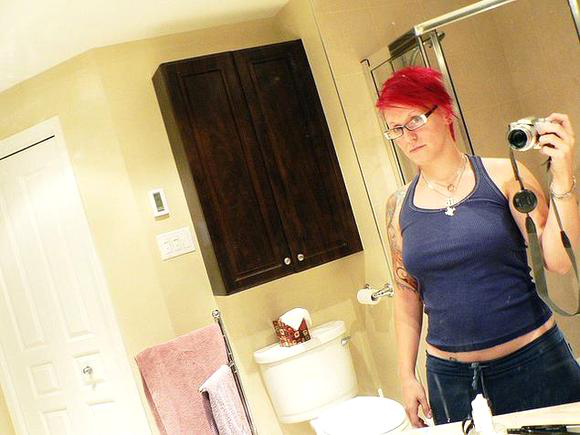

In [5]:
image_path = 'image/test'
image = 'test_00000'
Image.open(f'{image_path}/{image}.jpg').convert('RGB')

In [6]:
from source_code.model import *
import glob
models = glob.glob('model/*')

In [8]:
# device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"current device is {device}")

question = 'What is her hair color?'#input()
print('Question: ',question)
test_df = pd.DataFrame({"image_id":[image], "question":[question]})

# Model
for model_ in models:
    # dataset & dataloader
    if 'gpt' in model_.lower():
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    elif 'bert' in model_.lower():
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    vocab_size = len(tokenizer)
    
    #model
    VQAModel = Resnet_GPT2      #####수정 필요

    checkpoint = torch.load(model_, map_location ='cpu') #모델
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
    epoch = checkpoint['epoch']

#    if model_[6:] == 'ResNet50_GPT2_1epoch.pth':
    test_dataset = VQADataset(test_df, tokenizer, transform, test_img_path, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    preds = inference(model, test_loader)

    for pred in preds:
        output = pred[pred != 50257] # [PAD] token 제외
    print('Model: ', model_)
    print('Answer: ', tokenizer.decode(output).strip()) # 토큰 id -> 토큰
Image.open(f'{image_path}/{image}.jpg').convert('RGB')

current device is cpu
Question:  What is her hair color?


  0%|          | 0/1 [00:00<?, ?it/s]

Model:  model\ResNet50_GPT2_1epoch.pth
Answer:  white


  0%|          | 0/1 [00:00<?, ?it/s]

Model:  model\ResNet50_GPT2_2epoch.pth
Answer:  to


RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory